In [1]:
%matplotlib inline
import os
import sys
import random
import numpy as np
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sys.path.append(os.path.dirname(os.getcwd()))
from src.pointnet import PointNet

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True


In [3]:
num_points = 1000   # 一ケース当たりのデータ点数
num_classes = 10    # 分類クラス数
activation = 'relu' # 活性化関数

# データの確認

In [13]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [14]:
file_path = r"D:\Projects\deeplearning\PointNet\data\ModelNet10\ModelNet10\chair\train\chair_0001.off"
with open(file_path, 'r') as f:
    mesh = read_off(f)

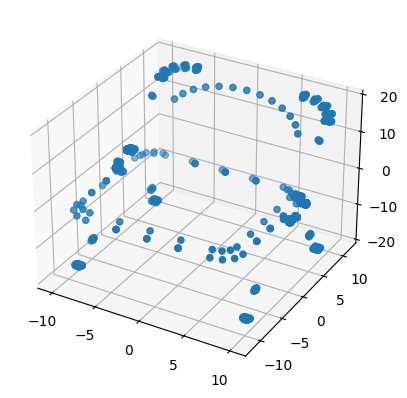

In [15]:
verts, face = mesh
verts = np.array(verts)

# 平面などは点がそこまで必要ではないためこのままでは何かわからない
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2])
plt.show()

In [16]:
verts, faces = mesh
areas = np.zeros((len(faces)))
verts = np.array(verts)

# function to calculate triangle area by its vertices
# https://en.wikipedia.org/wiki/Heron%27s_formula
def triangle_area(pt1, pt2, pt3):
    side_a = np.linalg.norm(pt1 - pt2)
    side_b = np.linalg.norm(pt2 - pt3)
    side_c = np.linalg.norm(pt3 - pt1)
    s = 0.5 * ( side_a + side_b + side_c)
    return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

# we calculate areas of all faces in our mesh
for i in range(len(areas)):
    areas[i] = (triangle_area(verts[faces[i][0]],
                              verts[faces[i][1]],
                              verts[faces[i][2]]))

In [17]:
# we sample 'k' faces with probabilities proportional to their areas
# weights are used to create a distribution.
# they don't have to sum up to one.
sampled_faces = (random.choices(faces, 
                                weights=areas,
                                k=num_points))

# function to sample points on a triangle surface
def sample_point(pt1, pt2, pt3):
    # barycentric coordinates on a triangle
    # https://mathworld.wolfram.com/BarycentricCoordinates.html
    s, t = sorted([random.random(), random.random()])
    f = lambda i: s * pt1[i] + (t-s) * pt2[i] + (1-t) * pt3[i]
    return (f(0), f(1), f(2))
 
pointcloud = np.zeros((num_points, 3))

# sample points on chosen faces for the point cloud of size 'k'
for i in range(len(sampled_faces)):
    pointcloud[i] = (sample_point(verts[sampled_faces[i][0]],
                                  verts[sampled_faces[i][1]],
                                  verts[sampled_faces[i][2]]))

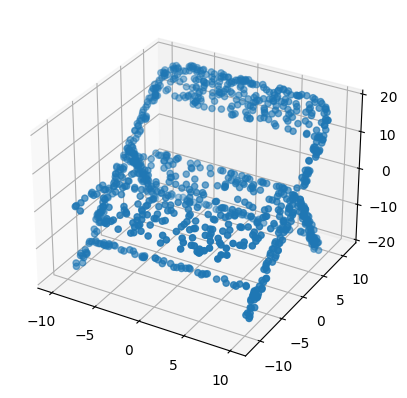

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2])
plt.show()


# データセットの準備

In [123]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_pattern, labels, classes, batch_size: int=1, shuffle=False):
        if len(file_pattern) != len(labels):
            raise Exception('Invalid dataset.')
        self.file_pattern = file_pattern
        self.labels = labels
        self.classes = classes
        self.batch_size = batch_size
        
        if shuffle:
            data = list(zip(self.file_pattern, self.labels))
            random.shuffle(data)
            self.file_pattern, self.labels = zip(*data)
            self.file_pattern = list(self.file_pattern)
            self.labels = list(self.labels)

    def __len__(self):
        return np.ceil(len(self.file_pattern) / self.batch_size).astype('int')

    def read_off(self, file):
        if 'OFF' != file.readline().strip():
            raise('Not a valid OFF header')
        n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
        verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
        faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
        return verts, faces
    
    def _data_parser(self, file_path):
        with open(file_path, 'r') as f:
            mesh = self.read_off(f)

        verts, faces = mesh
        areas = np.zeros((len(faces)))
        verts = np.array(verts)
        
        for i in range(len(areas)):
            areas[i] = (triangle_area(verts[faces[i][0]],
                                      verts[faces[i][1]],
                                      verts[faces[i][2]]))
        
        sampled_faces = (random.choices(faces, 
                                        weights=areas,
                                        k=num_points))

        pointcloud = np.zeros((num_points, 3))

        # sample points on chosen faces for the point cloud of size 'k'
        for i in range(len(sampled_faces)):
            pointcloud[i] = (sample_point(verts[sampled_faces[i][0]],
                                          verts[sampled_faces[i][1]],
                                          verts[sampled_faces[i][2]]))

        # standardization
        pointcloud = (pointcloud - np.mean(pointcloud, axis=0)) / np.std(pointcloud, axis=0)
        return pointcloud
    
    def _label_parser(self, label):
        onehot_label = [1 if c == label else 0 for i, c in enumerate(self.classes)]
        return onehot_label

    def __getitem__(self, idx):
        batch_file_pattern = self.file_pattern[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size:(idx+1)*self.batch_size]
        
        batch_x = np.array([self._data_parser(path) for path in batch_file_pattern])
        batch_y = np.array([self._label_parser(label) for label in batch_labels])
        return batch_x, batch_y

In [124]:
data_pattern = Path(r"D:\Projects\deeplearning\PointNet\data\ModelNet10\ModelNet10").glob('**/*.*off')

train_file_pattern = []
train_label_pattern = []
test_file_pattern = []
test_label_pattern = []
for path in data_pattern:
    label = path.parents[1].name
    data_type = path.parent.name
    if data_type == 'train':
        train_file_pattern.append(str(path))
        train_label_pattern.append(label)
    elif data_type == 'test':
        test_file_pattern.append(str(path))
        test_label_pattern.append(label)

classes = list(set(train_label_pattern))

# モデルの学習

In [128]:
train_gen = DataGenerator(train_file_pattern, train_label_pattern, classes=classes, shuffle=True)
test_gen = DataGenerator(test_file_pattern, test_label_pattern, classes=classes)

In [129]:
model = PointNet(num_points, num_classes, activation)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [130]:
model.fit(x=train_gen, epochs=15, steps_per_epoch=len(train_gen))

Epoch 1/15
3991/3991 [==============================] - 687s 171ms/step - loss: 2.1929 - accuracy: 0.2225
Epoch 2/15
3991/3991 [==============================] - 677s 170ms/step - loss: 2.1417 - accuracy: 0.2228
Epoch 3/15
3991/3991 [==============================] - 681s 171ms/step - loss: 2.1381 - accuracy: 0.2228
Epoch 4/15
3991/3991 [==============================] - 677s 170ms/step - loss: 2.1376 - accuracy: 0.2228
Epoch 5/15
3991/3991 [==============================] - 654s 164ms/step - loss: 2.1376 - accuracy: 0.2228
Epoch 6/15
3991/3991 [==============================] - 653s 164ms/step - loss: 2.1373 - accuracy: 0.2228
Epoch 7/15
3991/3991 [==============================] - 662s 166ms/step - loss: 2.1376 - accuracy: 0.2228
Epoch 8/15
3991/3991 [==============================] - 666s 167ms/step - loss: 2.1375 - accuracy: 0.2228
Epoch 9/15
3991/3991 [==============================] - 734s 184ms/step - loss: 2.1375 - accuracy: 0.2228
Epoch 10/15
3991/3991 [=======================